# Homework 4: Change Detection

In [ ]:
# if 'google.colab' in str(get_ipython()):
#     !pip install torchmetrics

In [2]:
# from google.colab import drive
# drive.mount('drive')

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Using torch device type: {device}")

Using torch device type: cuda


# Supervised Change Detection

For this programming assignment, you will be experimenting with a pixel-level labeling method for the task of foreground detection using a subset of the [changedetection.net](http://jacarini.dinf.usherbrooke.ca/) (links to an external site) dataset.  Most approaches to this problem use an unsupervised approach, in which you first learn what is normal for every pixel and then classify new pixels as normal (background) or abnormal (foreground).  We take a supervised learning approach using a convolutional neural network. We will be implementing this in PyTorch.

### Dataset Creation
We first create a dataset that allows us to read the image and appropriate labels from the data directory

In [4]:
from dataset import MyDataset

In [5]:
def get_dataloaders(data_dir, batch_size=32, num_workers=2):
  #define train and test datasets
  train_data = MyDataset(data_dir)
  test_data = MyDataset(data_dir, train=False)
  test_data, valid_data = torch.utils.data.random_split(test_data, [0.5,0.5])
  #define train and test dataloaders
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
  test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=False, drop_last=True)
  valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=False, drop_last=True)

  return train_dataloader, test_dataloader, valid_dataloader

While not required, you can upload your data to your Google Drive, which will make it permanent. That way you will not need to upload the data everytime you restart your session.

Using `!` you can use terminal commands such as `!ls` or `!pwd` to find out the path to your data. Your Google Drive will have the path `./drive/MyDrive`.

Set `data_dir` variable to the appropriate path as it will be used to access the data throughout the rest of the notebook.

In [9]:
!ls 

__pycache__
data
dataset.py
main.ipynb


In [10]:
# set the data directory to the appropriate directory
data_dir = './data/'
# set batch_size and number of workers
batch_size = 6
num_workers = 2
train_dataloader, test_dataloader, valid_dataloader = get_dataloaders(data_dir, batch_size, num_workers)

### Visualizing the Data
Once your dataloaders are ready, we can visualize our data. The code block plots a couple of examples from the training set. The left column shows your input and the right column shows the labels.

The labels only have three unique pixel values. The yellow pixels represent foreground, the dark pixels represent background, and the green pixels represent ignore classes.

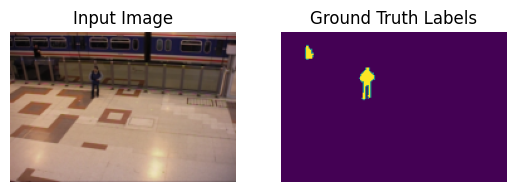

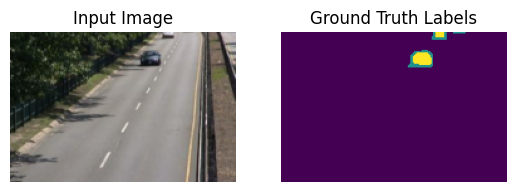

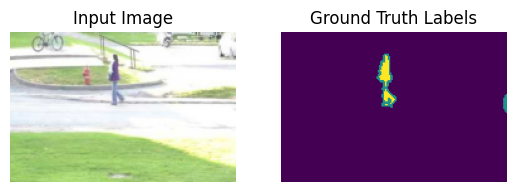

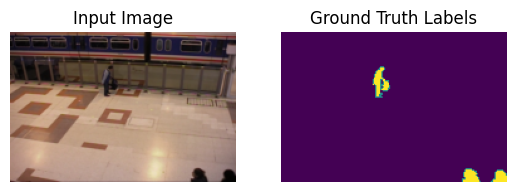

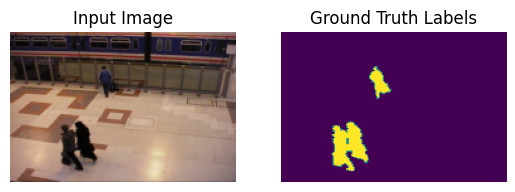

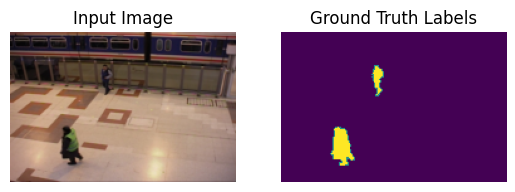

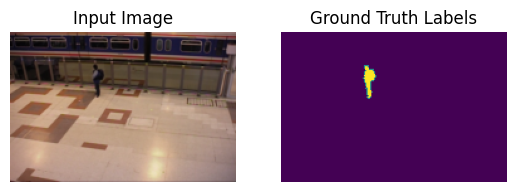

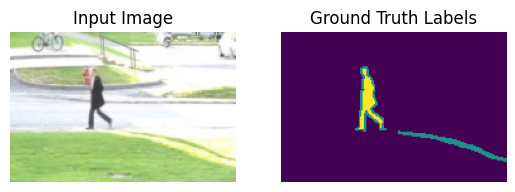

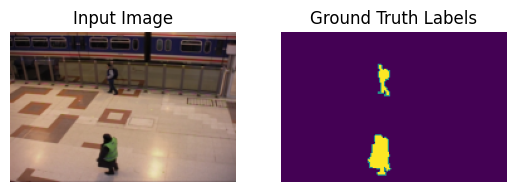

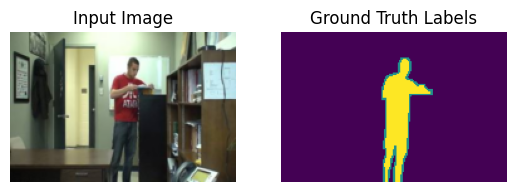

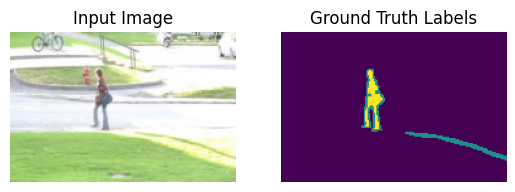

In [11]:
def visualize_data(dataloader):
  for index, (ims, labels) in enumerate(dataloader):
      labels = torch.permute(labels, (0,2,3,1))
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(1)
      plt.clf()

      plt.subplot(1,2,1)
      plt.imshow(ims[0,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(labels[0,:,:,:].squeeze(),clim=(0.0,2.0))
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

visualize_data(train_dataloader)

### Metrics
We will define three functions in this section: **precision**, **recall**, and **f1**. These metrics will allow us to evaluate the efficacy of our model.

In [13]:
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
from tqdm import tqdm

def precision(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
  prec = MulticlassPrecision(average='macro', num_classes=3, ignore_index=1).to(device)
  batch_precision = prec(y_true, y_pred)
  return batch_precision

def recall(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
  rec = MulticlassRecall(average='macro', num_classes=3, ignore_index=1).to(device)
  batch_precision = rec(y_true, y_pred)
  return batch_precision

def f_measure(y_true, y_pred):
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)
  fmeasure = 2*(p * r)/(p + r + 1e-7)
  return fmeasure

In [14]:
y_pred = torch.randn(3,3,120,180).to(device)
y_true = torch.randint(0, 3, size=(3, 1, 120, 180)).to(device)

In [15]:
print(f_measure(y_true, y_pred))

tensor(0.2662, device='cuda:0')


# Dealing With Class Imbalance

There are three classes in this task: 0) background, 1) unknown, and 2) foreground. Unfortunately, the training dataset has a "class balance" problem, meaning there are many more background pixels than foreground pixels. This can lead to a model that only predicts background. To overcome this problem, we have a special purpose loss function that enables different types of errors to be penalized differently. The default setting, is class_weights = [.25,0,1].  This means that:

Classifying a true foreground pixel as background or unknown has the highest loss.
Classifying a true background pixel as foreground or unknown has only 1/4 the penalty.
Classifying an unknown pixel results in no loss regardless of the resulting label.

Your task is to train three models:

- using the default class weight
- using class_weights= [.01,0,1]
- using class_weights= [1,0,1].  

Use the baseline neural network and optimizer settings for this task.  Include the Loss, Precision, Recall, and F-Measure for all three settings.  Also, explain what you observe in the **Discussion**.





In [16]:
class Baseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, (3,3), padding='same')
    self.bnorm1 = nn.BatchNorm2d(32, momentum=0.9, affine=False)
    self.conv2 = nn.Conv2d(32, 32, (3,3), padding='same')
    self.bnorm2 = nn.BatchNorm2d(32, momentum=0.9, affine=False)
    self.conv3 = nn.Conv2d(32, 3, (3,3), padding='same')

  def forward(self, x):
    x = self.bnorm1(nn.functional.leaky_relu(self.conv1(x), 0.1))
    x = self.bnorm2(nn.functional.leaky_relu(self.conv2(x), 0.1))
    output = self.conv3(x)
    return output

In [17]:
@torch.no_grad
def validate(model, dataloader,criterion):
  model.eval()
  model.to(device)
  running_loss = 0.0
  all_outputs = []
  all_labels = []
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)

    #save all outputs
    all_outputs.append(outputs)
    all_labels.append(labels)

  # Calculate epoch loss and eval metrics
  epoch_loss = running_loss / len(dataloader.dataset)
  all_outputs = torch.cat(all_outputs, dim=0)
  all_labels = torch.cat(all_labels, dim=0)
  all_labels = torch.unsqueeze(all_labels, dim=1)
  f1 = f_measure(all_labels, all_outputs).item()

  print(f'Val Loss: {epoch_loss:.3f} \t F1-Score: {f1}')

  return epoch_loss, f1

In [18]:
def training_loop(model, dataloader,criterion,optimizer):
  model.train()
  model.to(device)
  running_loss = 0.0

  progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True)
  for i, (inputs, labels) in progress_bar:
    inputs = inputs.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # import code;code.interact(local=dict(globals(), **locals()))
    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    progress_bar.set_description(f"Train Loss: {loss.item()}")

  progress_bar.close()
  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  print(f"Train Loss: {epoch_loss:.3f}")

  return epoch_loss

In [19]:
def fit(hparams, train_loader, valid_loader, model_name='test'):
  model = hparams['model_type']()
  best_loss = np.inf
  f1 = 0

  results = dict(train_loss=[], val_loss=[], val_f1=[])
  #initialize the optimizers
  if hparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  elif hparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
  else:
    raise NotImplementedError

  #initialize loss
  criterion = nn.CrossEntropyLoss(weight=torch.tensor(hparams['class_weights'], device=device, dtype=torch.float32))

  #run training for n epochs
  for epoch in range(hparams['n_epochs']):
    print("Epoch {}".format(epoch+1))
    train_loss = training_loop(model, train_loader,criterion,optimizer)
    val_loss, val_f1 = validate(model, valid_loader, criterion)

    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['val_f1'].append(val_f1)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      f1 = val_f1


  torch.save(best_model, f'{model_name}.pt')

  return best_model, best_loss, f1, results

In [20]:
def get_hparams(model_type=Baseline,n_epochs=10,learning_rate=1e-4, class_weights=[0.25, 0, 1], optimizer='adam'):
  hparams = {}
  hparams['n_epochs'] = n_epochs
  hparams['learning_rate'] = learning_rate
  hparams['model_type'] = model_type
  hparams['optimizer'] = optimizer
  hparams['class_weights'] = class_weights
  return hparams

Below, train 3 models using the different class weights defined earlier and display the results.

_Points:_ 5

In [ ]:
# For students using an mps device, the following may reduce some warnings during training
# !export MallocStackLoggingNoCompact=1

In [ ]:
# provide your training code below, and save your results to the variable "results"
results = []

# Code Goes Here:
#######################################
class_weights_list = [[0.25, 0, 1]]

for cw in class_weights_list:
    hparams = get_hparams(class_weights=cw, n_epochs=1)
    model, val_loss, f1, _ = fit(
        hparams, 
        train_dataloader, 
        valid_dataloader, 
        model_name=f'baseline_cw_{cw}'
    )
    results.append((cw, val_loss, f1))
#######################################


Epoch 1


Train Loss: 0.7225260734558105: 100%|██████████| 394/394 [00:57<00:00,  6.87it/s]


Train Loss: 0.910


100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


Val Loss: 0.732 	 F1-Score: 0.46517738699913025
Epoch 2


Train Loss: 0.4481983482837677: 100%|██████████| 394/394 [00:24<00:00, 16.37it/s] 


Train Loss: 0.570


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Val Loss: 0.572 	 F1-Score: 0.4719630181789398
Epoch 3


Train Loss: 0.6394177675247192: 100%|██████████| 394/394 [00:23<00:00, 16.88it/s] 


Train Loss: 0.376


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


Val Loss: 0.416 	 F1-Score: 0.46392321586608887
Epoch 4


Train Loss: 0.35096362233161926: 100%|██████████| 394/394 [00:25<00:00, 15.24it/s]


Train Loss: 0.285


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


Val Loss: 0.386 	 F1-Score: 0.4831847846508026
Epoch 5


Train Loss: 0.266950398683548: 100%|██████████| 394/394 [00:28<00:00, 13.95it/s]  


Train Loss: 0.233


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


Val Loss: 0.288 	 F1-Score: 0.5171789526939392
Epoch 6


Train Loss: 0.3234439492225647: 100%|██████████| 394/394 [00:23<00:00, 17.09it/s] 


Train Loss: 0.202


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


Val Loss: 0.267 	 F1-Score: 0.5215222239494324
Epoch 7


Train Loss: 0.22445979714393616: 100%|██████████| 394/394 [00:22<00:00, 17.37it/s]


Train Loss: 0.179


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


Val Loss: 0.230 	 F1-Score: 0.5391837358474731
Epoch 8


Train Loss: 0.3189113736152649: 100%|██████████| 394/394 [00:22<00:00, 17.27it/s] 


Train Loss: 0.162


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


Val Loss: 0.379 	 F1-Score: 0.4784296751022339
Epoch 9


Train Loss: 0.13107454776763916: 100%|██████████| 394/394 [00:24<00:00, 16.18it/s]


Train Loss: 0.150


100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


Val Loss: 0.226 	 F1-Score: 0.5304881930351257
Epoch 10


Train Loss: 0.24256984889507294: 100%|██████████| 394/394 [00:23<00:00, 16.45it/s]


Train Loss: 0.139


100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


Val Loss: 0.209 	 F1-Score: 0.544700026512146
Epoch 1


Train Loss: 1.0639173984527588: 100%|██████████| 394/394 [00:24<00:00, 16.13it/s] 


Train Loss: 0.539


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


Val Loss: 0.329 	 F1-Score: 0.39538219571113586
Epoch 2


Train Loss: 0.768704354763031: 100%|██████████| 394/394 [00:22<00:00, 17.21it/s]  


Train Loss: 0.437


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Val Loss: 0.293 	 F1-Score: 0.41217344999313354
Epoch 3


Train Loss: 0.26563671231269836: 100%|██████████| 394/394 [00:21<00:00, 18.64it/s]


Train Loss: 0.395


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


Val Loss: 0.263 	 F1-Score: 0.45501264929771423
Epoch 4


Train Loss: 0.23108893632888794: 100%|██████████| 394/394 [00:23<00:00, 16.90it/s]


Train Loss: 0.356


100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


Val Loss: 0.238 	 F1-Score: 0.4620896875858307
Epoch 5


Train Loss: 0.4590873122215271: 100%|██████████| 394/394 [00:30<00:00, 13.10it/s] 


Train Loss: 0.322


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Val Loss: 0.299 	 F1-Score: 0.4183976352214813
Epoch 6


Train Loss: 0.38943931460380554: 100%|██████████| 394/394 [00:24<00:00, 16.13it/s]


Train Loss: 0.295


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Val Loss: 0.200 	 F1-Score: 0.44479820132255554
Epoch 7


Train Loss: 0.3580186367034912: 100%|██████████| 394/394 [00:21<00:00, 18.61it/s] 


Train Loss: 0.263


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Val Loss: 0.266 	 F1-Score: 0.4260978102684021
Epoch 8


Train Loss: 0.5729125738143921: 100%|██████████| 394/394 [00:20<00:00, 18.99it/s] 


Train Loss: 0.237


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Val Loss: 0.192 	 F1-Score: 0.44345417618751526
Epoch 9


Train Loss: 0.6885492205619812: 100%|██████████| 394/394 [00:21<00:00, 18.23it/s] 


Train Loss: 0.217


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Val Loss: 0.304 	 F1-Score: 0.4145035445690155
Epoch 10


Train Loss: 0.15604953467845917: 100%|██████████| 394/394 [00:21<00:00, 18.54it/s]


Train Loss: 0.196


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Val Loss: 0.183 	 F1-Score: 0.5188456773757935
Epoch 1


Train Loss: 0.7895054221153259: 100%|██████████| 394/394 [00:23<00:00, 16.59it/s]


Train Loss: 0.950


100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


Val Loss: 0.765 	 F1-Score: 0.4860367476940155
Epoch 2


Train Loss: 0.46472203731536865: 100%|██████████| 394/394 [00:22<00:00, 17.45it/s]


Train Loss: 0.580


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Val Loss: 0.518 	 F1-Score: 0.48125895857810974
Epoch 3


Train Loss: 0.3386183977127075: 100%|██████████| 394/394 [00:22<00:00, 17.76it/s] 


Train Loss: 0.345


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Val Loss: 0.438 	 F1-Score: 0.4889601469039917
Epoch 4


Train Loss: 0.2427322119474411: 100%|██████████| 394/394 [00:23<00:00, 17.02it/s] 


Train Loss: 0.229


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


Val Loss: 0.241 	 F1-Score: 0.47467678785324097
Epoch 5


Train Loss: 0.19923080503940582: 100%|██████████| 394/394 [00:22<00:00, 17.56it/s]


Train Loss: 0.170


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Val Loss: 0.217 	 F1-Score: 0.5039726495742798
Epoch 6


Train Loss: 0.13339169323444366: 100%|██████████| 394/394 [00:22<00:00, 17.77it/s]


Train Loss: 0.135


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Val Loss: 0.182 	 F1-Score: 0.5180327296257019
Epoch 7


Train Loss: 0.13862521946430206: 100%|██████████| 394/394 [00:22<00:00, 17.32it/s]


Train Loss: 0.113


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Val Loss: 0.244 	 F1-Score: 0.4686335027217865
Epoch 8


Train Loss: 0.07890219986438751: 100%|██████████| 394/394 [00:22<00:00, 17.63it/s]


Train Loss: 0.097


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Val Loss: 0.152 	 F1-Score: 0.5239850282669067
Epoch 9


Train Loss: 0.1796441674232483: 100%|██████████| 394/394 [00:21<00:00, 17.92it/s]  


Train Loss: 0.087


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


Val Loss: 0.122 	 F1-Score: 0.5330000519752502
Epoch 10


Train Loss: 0.08150723576545715: 100%|██████████| 394/394 [00:23<00:00, 16.53it/s] 


Train Loss: 0.079


100%|██████████| 32/32 [00:21<00:00,  1.52it/s]


Val Loss: 0.125 	 F1-Score: 0.5374395847320557


In [41]:
# Report your results using the below line
# The expected results format is shown below:
# results = [
#     ([.25, 0, 1], 0.209, 0.545),
#     ([.01, 0, 1], 0.183, 0.519),
#     ([1, 0, 1], 0.125, 0.537),
# ]

df = pd.DataFrame(results, columns=["Class Weights", "Best Validation Loss", "F1 Score"])
df

,Class Weights,Best Validation Loss,F1 Score
0,"[0.25, 0, 1]",0.209,0.545
1,"[0.01, 0, 1]",0.183,0.519
2,"[1, 0, 1]",0.125,0.537


# Define Custom Models
We provided a simple `Baseline` model as a reference. In this section you will create atleast two new Models. Try to make distinct choices between the two models. Feel free to experiment with different layers, architectures, regularization, size etc.   

In [24]:
class Model1(nn.Module):
  def __init__(self):
    super().__init__()
    ######## CODE BELOW ############
    self.conv1 = nn.Conv2d(3, 64, 3, padding='same')
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, padding='same')
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, padding='same')
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 3, 3, padding='same')
    ######## CODE ABOVE ############

  def forward(self, x):
    ####### CODE BELOW ############
    x = nn.functional.leaky_relu(self.bn1(self.conv1(x)), 0.1)
    x = nn.functional.leaky_relu(self.bn2(self.conv2(x)), 0.1)
    x = nn.functional.leaky_relu(self.bn3(self.conv3(x)), 0.1)
    x = self.conv4(x)
    output = x
    ####### CODE ABOVE ############
    return output

# verify instantiability
model1 = Model1()
inputs = torch.rand(2,3,64,64)
print(inputs.device)
model1(inputs).shape


cpu


torch.Size([2, 3, 64, 64])

In [26]:
class Model2(nn.Module):
  def __init__(self):
    super().__init__()
    ######## CODE BELOW ############
    self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.adjust_channel = nn.Conv2d(64, 32, 1)  
    self.conv3 = nn.Conv2d(32, 32, 3, padding='same')
    self.conv4 = nn.Conv2d(32, 3, 3, padding='same')
    ######## CODE ABOVE ############

  def forward(self, x):
    ####### CODE BELOW ############
    x1 = nn.functional.relu(self.conv1(x))     
    x = self.pool(x1)                          
    x = nn.functional.relu(self.conv2(x))      
    x = self.up(x)                             
    x = self.adjust_channel(x)                 
    x = x + x1                                 
    x = nn.functional.relu(self.conv3(x))      
    x = self.conv4(x)    
    output = x
    ####### CODE ABOVE ############
    return output

# verify instantiability
model2 = Model2()
inputs = torch.rand(2,3,64,64)
print(inputs.device)
model2(inputs).shape


cpu


torch.Size([2, 3, 64, 64])

### Experimenting With Hyperparameters
You will run fit on each of the above models atleast once. After that you can experiment with any combination of models and hyperparameters including and beyond the list provided in the `get_hparams` function. Feel free to add new keys to the hparams dictionary as needed. Everytime you run the `fit` script, the best model from that run gets saved as `{model_name}.pt`. This is saved in the temporary directory so make sure to move it to your desired directory in the drive to use it later (or just set the intented directory in the fit funtion). You will also plot the validation loss and f1-score for the training runs.

We provide a `load_model` function that allows you to load a save model. Note that the respective model class has to be defined to use this functionality

In [27]:
def load_model(path):
  model = torch.load(path, weights_only=False)
  return model

<!-- BEGIN QUESTION -->



Epoch 1


Train Loss: 0.0917271226644516: 100%|██████████| 394/394 [00:27<00:00, 14.10it/s]  


Train Loss: 0.147


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Val Loss: 0.169 	 F1-Score: 0.5573818683624268
Epoch 2


Train Loss: 0.0685940608382225: 100%|██████████| 394/394 [00:31<00:00, 12.34it/s]  


Train Loss: 0.071


100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


Val Loss: 0.095 	 F1-Score: 0.5991870164871216
Epoch 3


Train Loss: 0.023833099752664566: 100%|██████████| 394/394 [00:31<00:00, 12.55it/s]


Train Loss: 0.052


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


Val Loss: 0.084 	 F1-Score: 0.594733476638794
Epoch 4


Train Loss: 0.040159523487091064: 100%|██████████| 394/394 [01:13<00:00,  5.37it/s]


Train Loss: 0.041


100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Val Loss: 0.068 	 F1-Score: 0.6114575266838074
Epoch 5


Train Loss: 0.05227402225136757: 100%|██████████| 394/394 [02:01<00:00,  3.24it/s] 


Train Loss: 0.035


100%|██████████| 32/32 [00:33<00:00,  1.06s/it]


Val Loss: 0.051 	 F1-Score: 0.6138593554496765
Epoch 6


Train Loss: 0.025926712900400162: 100%|██████████| 394/394 [01:54<00:00,  3.43it/s]


Train Loss: 0.029


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


Val Loss: 0.059 	 F1-Score: 0.6075794696807861
Epoch 7


Train Loss: 0.08780500292778015: 100%|██████████| 394/394 [01:49<00:00,  3.60it/s] 


Train Loss: 0.026


100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


Val Loss: 0.054 	 F1-Score: 0.6140369176864624
Epoch 8


Train Loss: 0.01054408773779869: 100%|██████████| 394/394 [01:58<00:00,  3.32it/s] 


Train Loss: 0.025


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Val Loss: 0.047 	 F1-Score: 0.6098377704620361
Epoch 9


Train Loss: 0.018172165378928185: 100%|██████████| 394/394 [02:14<00:00,  2.93it/s]


Train Loss: 0.021


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Val Loss: 0.048 	 F1-Score: 0.615814208984375
Epoch 10


Train Loss: 0.16473917663097382: 100%|██████████| 394/394 [01:50<00:00,  3.57it/s]  


Train Loss: 0.021


100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Val Loss: 0.037 	 F1-Score: 0.6145109534263611
Epoch 11


Train Loss: 0.07074432075023651: 100%|██████████| 394/394 [02:03<00:00,  3.20it/s]  


Train Loss: 0.017


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Val Loss: 0.049 	 F1-Score: 0.6122865080833435
Epoch 12


Train Loss: 0.01797456108033657: 100%|██████████| 394/394 [02:06<00:00,  3.12it/s]  


Train Loss: 0.016


100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Val Loss: 0.042 	 F1-Score: 0.6177035570144653
Epoch 13


Train Loss: 0.025070613250136375: 100%|██████████| 394/394 [02:14<00:00,  2.93it/s] 


Train Loss: 0.014


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Val Loss: 0.067 	 F1-Score: 0.6106418967247009
Epoch 14


Train Loss: 0.007199606858193874: 100%|██████████| 394/394 [01:58<00:00,  3.32it/s] 


Train Loss: 0.014


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Val Loss: 0.081 	 F1-Score: 0.611838698387146
Epoch 15


Train Loss: 0.019825421273708344: 100%|██████████| 394/394 [01:52<00:00,  3.50it/s] 


Train Loss: 0.014


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


Val Loss: 0.042 	 F1-Score: 0.6150586009025574
Epoch 16


Train Loss: 0.007980052381753922: 100%|██████████| 394/394 [02:00<00:00,  3.28it/s] 


Train Loss: 0.010


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Val Loss: 0.060 	 F1-Score: 0.5946744084358215
Epoch 17


Train Loss: 0.02919655106961727: 100%|██████████| 394/394 [01:52<00:00,  3.49it/s]  


Train Loss: 0.010


100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


Val Loss: 0.027 	 F1-Score: 0.6194128394126892
Epoch 18


Train Loss: 0.022672582417726517: 100%|██████████| 394/394 [01:57<00:00,  3.34it/s] 


Train Loss: 0.010


100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


Val Loss: 0.033 	 F1-Score: 0.6187388300895691
Epoch 19


Train Loss: 0.04067793861031532: 100%|██████████| 394/394 [02:07<00:00,  3.10it/s]  


Train Loss: 0.009


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Val Loss: 0.027 	 F1-Score: 0.6190376281738281
Epoch 20


Train Loss: 0.0038954513147473335: 100%|██████████| 394/394 [01:58<00:00,  3.31it/s]


Train Loss: 0.008


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Val Loss: 0.054 	 F1-Score: 0.6173885464668274
Epoch 1


Train Loss: 0.13780327141284943: 100%|██████████| 394/394 [00:19<00:00, 20.27it/s]


Train Loss: 0.380


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Val Loss: 0.473 	 F1-Score: 0.4381636381149292
Epoch 2


Train Loss: 0.09124023467302322: 100%|██████████| 394/394 [00:19<00:00, 20.43it/s]


Train Loss: 0.213


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Val Loss: 0.296 	 F1-Score: 0.47217878699302673
Epoch 3


Train Loss: 0.12492290884256363: 100%|██████████| 394/394 [00:21<00:00, 18.15it/s] 


Train Loss: 0.163


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Val Loss: 0.237 	 F1-Score: 0.5072181820869446
Epoch 4


Train Loss: 0.11743977665901184: 100%|██████████| 394/394 [00:19<00:00, 20.08it/s] 


Train Loss: 0.149


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Val Loss: 0.245 	 F1-Score: 0.5176441073417664
Epoch 5


Train Loss: 0.04045413061976433: 100%|██████████| 394/394 [00:19<00:00, 20.31it/s] 


Train Loss: 0.137


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Val Loss: 0.186 	 F1-Score: 0.5227896571159363
Epoch 6


Train Loss: 0.03238804265856743: 100%|██████████| 394/394 [00:19<00:00, 20.16it/s] 


Train Loss: 0.127


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Val Loss: 0.191 	 F1-Score: 0.5406462550163269
Epoch 7


Train Loss: 0.05654663220047951: 100%|██████████| 394/394 [00:19<00:00, 20.21it/s] 


Train Loss: 0.118


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Val Loss: 0.167 	 F1-Score: 0.5428079962730408
Epoch 8


Train Loss: 0.2107556313276291: 100%|██████████| 394/394 [00:19<00:00, 20.50it/s]  


Train Loss: 0.111


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Val Loss: 0.169 	 F1-Score: 0.5392706394195557
Epoch 9


Train Loss: 0.14960958063602448: 100%|██████████| 394/394 [00:19<00:00, 20.65it/s] 


Train Loss: 0.104


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Val Loss: 0.170 	 F1-Score: 0.5486438274383545
Epoch 10


Train Loss: 0.17656414210796356: 100%|██████████| 394/394 [00:18<00:00, 21.00it/s] 


Train Loss: 0.097


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Val Loss: 0.165 	 F1-Score: 0.5532383918762207
Epoch 11


Train Loss: 0.08548660576343536: 100%|██████████| 394/394 [00:19<00:00, 20.64it/s] 


Train Loss: 0.092


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Val Loss: 0.163 	 F1-Score: 0.5571169257164001
Epoch 12


Train Loss: 0.009194942191243172: 100%|██████████| 394/394 [00:18<00:00, 20.77it/s]


Train Loss: 0.087


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Val Loss: 0.147 	 F1-Score: 0.5613430142402649
Epoch 13


Train Loss: 0.0023458534851670265: 100%|██████████| 394/394 [00:19<00:00, 20.62it/s]


Train Loss: 0.082


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Val Loss: 0.160 	 F1-Score: 0.5605837106704712
Epoch 14


Train Loss: 0.05504213646054268: 100%|██████████| 394/394 [00:18<00:00, 20.81it/s] 


Train Loss: 0.077


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Val Loss: 0.143 	 F1-Score: 0.5665743947029114
Epoch 15


Train Loss: 0.16410225629806519: 100%|██████████| 394/394 [00:19<00:00, 19.80it/s] 


Train Loss: 0.074


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Val Loss: 0.120 	 F1-Score: 0.5694620013237
Epoch 16


Train Loss: 0.01585174910724163: 100%|██████████| 394/394 [00:19<00:00, 20.15it/s] 


Train Loss: 0.070


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Val Loss: 0.123 	 F1-Score: 0.5742894411087036
Epoch 17


Train Loss: 0.03682198375463486: 100%|██████████| 394/394 [00:19<00:00, 20.11it/s] 


Train Loss: 0.067


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Val Loss: 0.169 	 F1-Score: 0.5724329352378845
Epoch 18


Train Loss: 0.02710394747555256: 100%|██████████| 394/394 [00:19<00:00, 19.73it/s] 


Train Loss: 0.065


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Val Loss: 0.144 	 F1-Score: 0.5795665383338928
Epoch 19


Train Loss: 0.01086823083460331: 100%|██████████| 394/394 [00:19<00:00, 19.97it/s] 


Train Loss: 0.062


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Val Loss: 0.151 	 F1-Score: 0.5778802037239075
Epoch 20


Train Loss: 0.014335029758512974: 100%|██████████| 394/394 [00:19<00:00, 20.01it/s]


Train Loss: 0.061


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Val Loss: 0.127 	 F1-Score: 0.5856409668922424


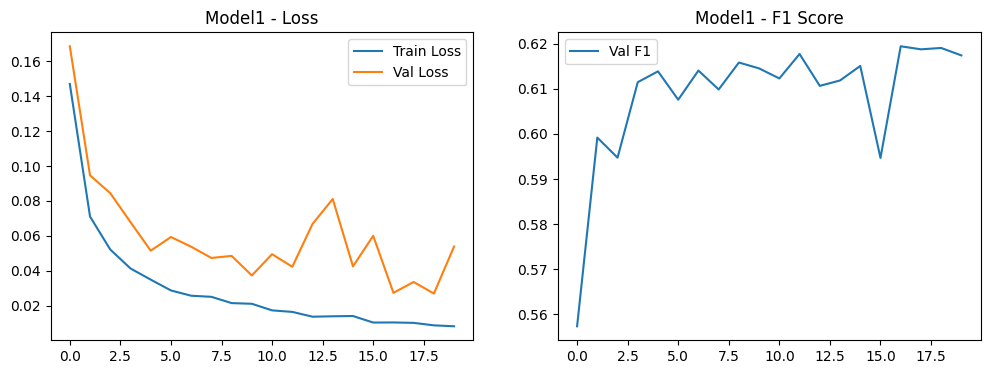

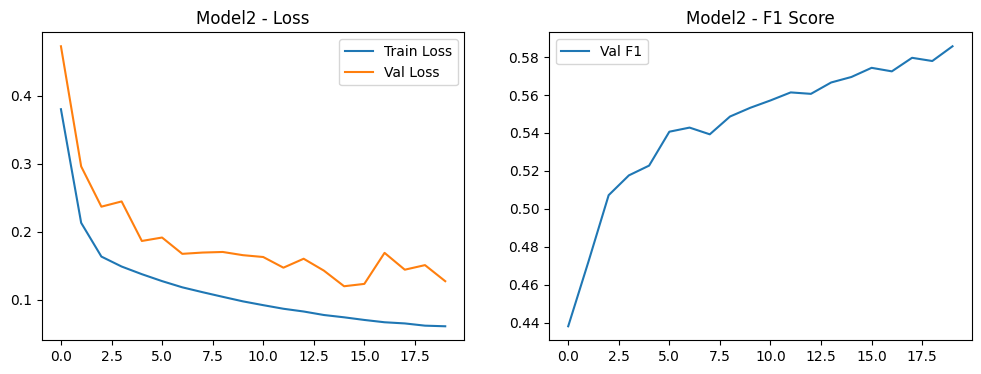

In [ ]:
## Fit and plot results below

# use different calls to get_hparams to access different models and hyperparameters
# e.g.   > hparams = get_hparams()
#        > model, val_loss, f1, results = fit(hparams, train_dataloader, valid_dataloader, model_name='')

######## CODE BELOW ############
hparams_model1 = get_hparams(
    model_type=Model1,
    n_epochs=1,
    learning_rate=1e-4,
    optimizer='adam'
)
model1, val_loss1, f1_1, results1 = fit(
    hparams_model1, 
    train_dataloader, 
    valid_dataloader, 
    model_name='model1'
)

hparams_model2 = get_hparams(
    model_type=Model2,
    n_epochs=1,
    learning_rate=1e-4,
    optimizer='adam'
)
model2, val_loss2, f1_2, results2 = fit(
    hparams_model2, 
    train_dataloader, 
    valid_dataloader, 
    model_name='model2'
)

######## CODE ABOVE ############

# write code to plot the f1 and val_loss across different epochs for each run 
# Hint: use the results variable returned by fit. Make sure the plots are visible in the output below

######## CODE BELOW ############
def plot_results(results, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(results['val_f1'], label='Val F1')
    plt.title(f'{title} - F1 Score')
    plt.legend()
    plt.show()

plot_results(results1, 'Model1')
plot_results(results2, 'Model2')
######## CODE ABOVE ############


<!-- END QUESTION -->

### Visualize the results on the test set

In [29]:
import matplotlib.pyplot as plt

@torch.no_grad
def visualize(model, dataloader):
  for index, (ims, labels) in enumerate(dataloader):
      ims = ims.to(device)
      labels_est = model(ims)
      # import code;code.interact(local=dict(globals(), **locals()))
      labels = torch.permute(labels, (0,2,3,1)).cpu()
      labels_est = torch.permute(labels_est, (0,2,3,1)).cpu()
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(figsize=(15,8))
      plt.clf()

      num_img = np.random.randint(0,batch_size)
      plt.subplot(1,4,1)
      plt.imshow(ims[num_img,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,4,2)
      plt.imshow(labels[num_img,:,:,:].squeeze(),clim=(0.0,2.0))
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.subplot(1,4,3)
      plt.imshow(labels_est[num_img,:,:,2].squeeze(),clim=(0.0,1.0))
      plt.title('Probability of Foreground')
      plt.axis('off')

      plt.subplot(1,4,4)
      plt.imshow(np.argmax(labels_est[num_img,:,:,:],axis=-1),clim=(0.0,2.0))
      plt.title('Predicted Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

<!-- BEGIN QUESTION -->

Visualize your best model's performance below.

_Points:_ 5

In [39]:
# load your saved model
model = load_model('model1.pt')

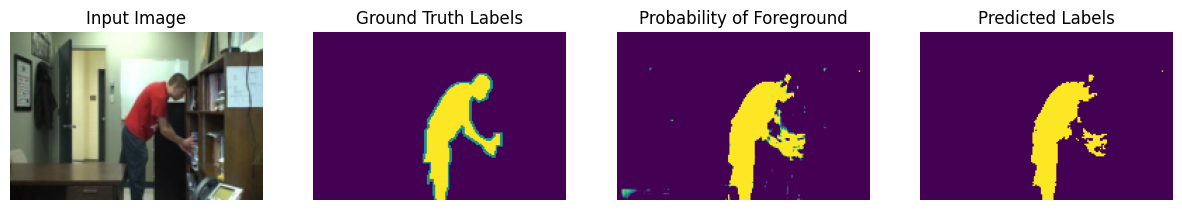

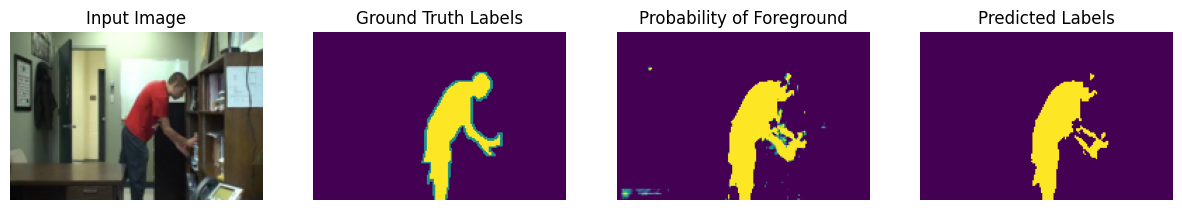

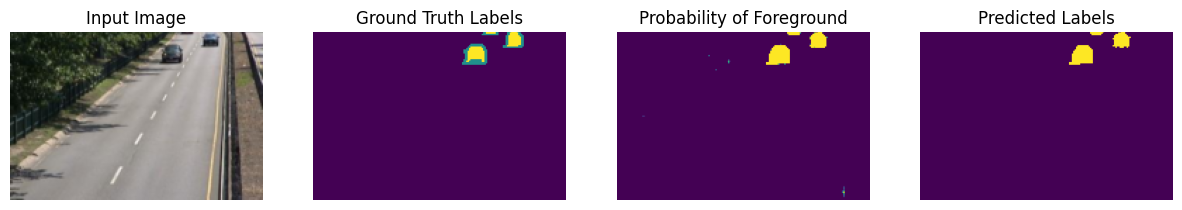

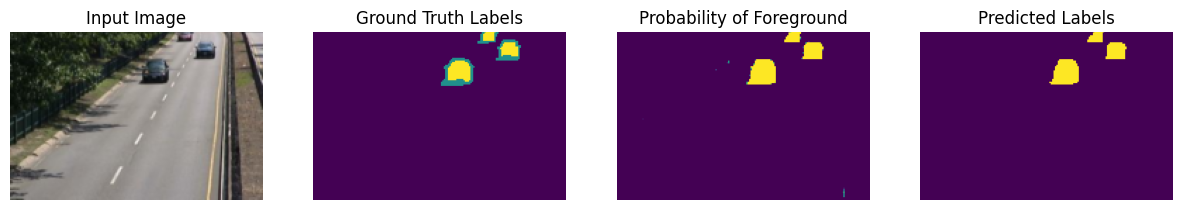

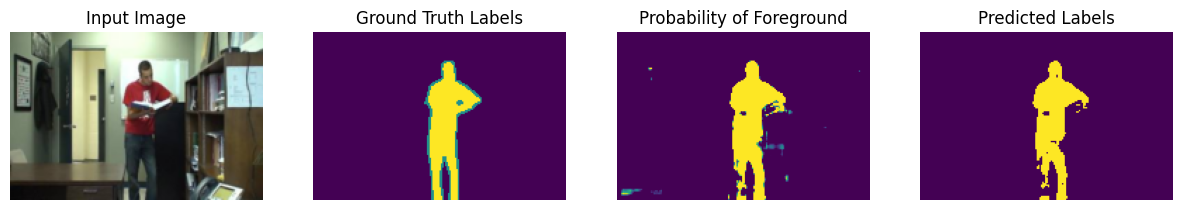

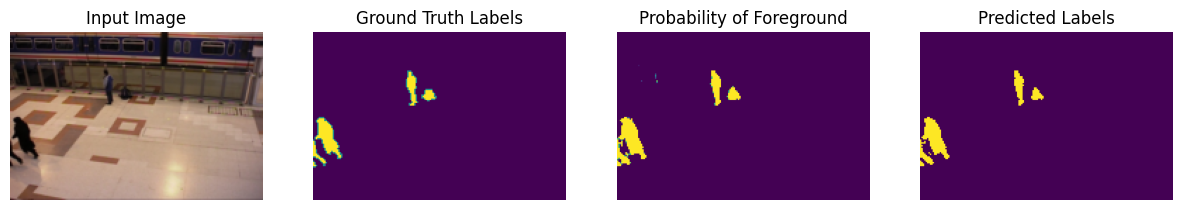

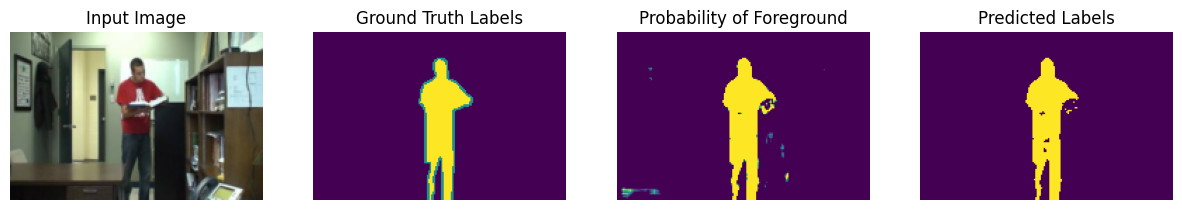

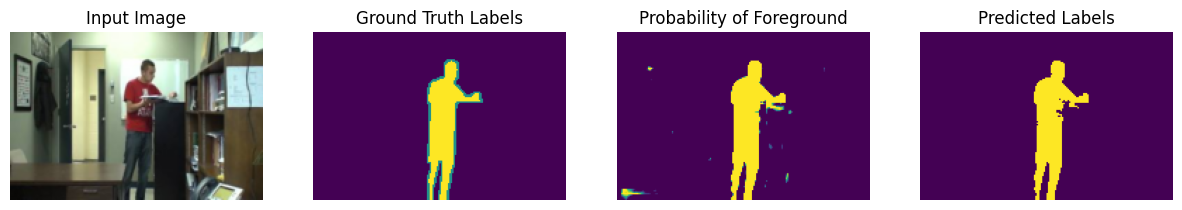

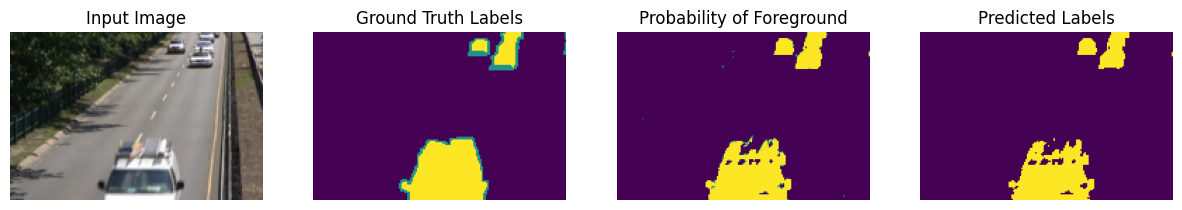

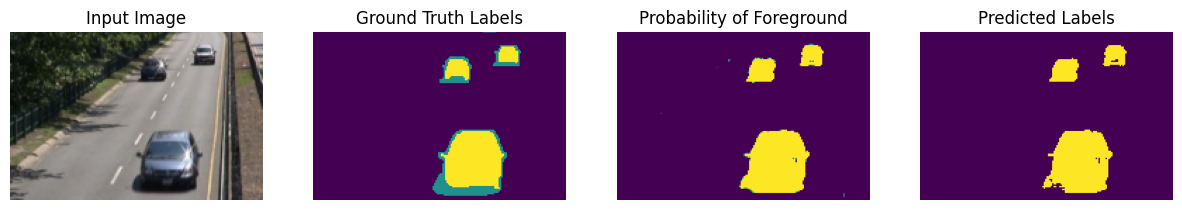

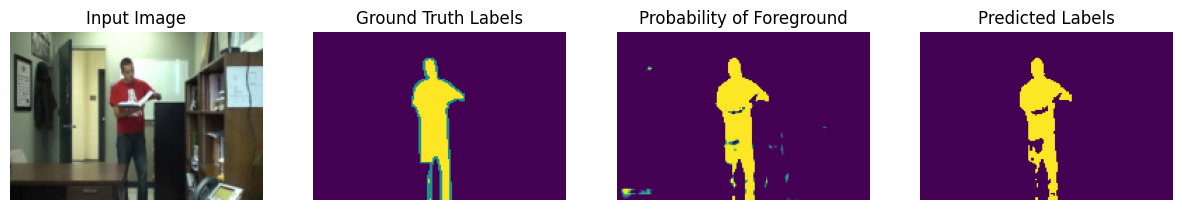

In [40]:
visualize(model, test_dataloader)

<!-- END QUESTION -->

# Discussion


<!-- BEGIN QUESTION -->

1. Explain the impact of using different class weights when training the baseline model. Visualize your results below and see if your can notice any specific pattern or bias that the model has learned in the three different scenarios.


_Points:_ 5

During the observation of the result, we have found that the when the class weight for background classification is low (0.25), the model will predict more towards the background. When the class weight is too low, drop to 0.01, the model will be encouraged to predict foreground and it is clear in the result showing that some of the road symbols other than cars has been mistakenly recognized as the foreground. Simil;arly, when we increase the classweight for the background, some foreground might be recognized as the the background. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

2. Explain the architectural choices of your two models. Describe about their performance. Try to reason about which specific choices (in architecture or hyperparameters) caused their specific behaviour. Describe your experiments with different hyperparameters.


_Points:_ 5

In the first model, I added convolution layers and batch normalization. Their ability to capture the feature is improved. The loss goes to convergence very quick. F1 score is 0.6, which is higher than the baseline model. The introduction of batch normalization works well for solving problems of gradient vanishing. 

In the second model, I added pooling and upsampling operations together with jump connection, trying to combine information from multidimension. The loss drops quickly but the f1 score is not as high as the model 1 but still much higher than the baseline. The jump connection keeps detailed information while the pooling can improve the robustness for recognizing the background. 

In both model, I tried hyperparameter like adam optimizer and 1e-4 learning rate to ensure the stable convergence and less likely to oscillating. 

<!-- END QUESTION -->

# Submission Instructions


Follow the instructions provided on the [canvas assignment page](https://wustl.instructure.com/courses/147292/assignments/762182).

# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]